In [1]:
import sys
import glob

import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def get_traj(file):
	df = pd.read_csv(file, names=('tag', 'ts', 'v1', 'v2', 'v3', 'v4'))

	df_s = df[df.tag == 'pos']
	df_s = df_s.rename(columns={'v1' : 'x', 'v2' : 'y', 'v3' : 'z', 'v4' : 'a'})


	df_u = df[df.tag == 'input']
	df_u = df_u.rename(columns={'v1' : 'roll', 'v2' : 'pitch', 'v3' : 'yaw', 'v4' : 'throttle'})

	x, y, z, a = [df_s[v].to_numpy() for v in ['x', 'y', 'z', 'a']]
	roll, pitch, yaw, throttle = [df_u[v].to_numpy() for v in ['roll', 'pitch', 'yaw', 'throttle']]
	
	s = np.stack([x, y, z, a]).T
	u = np.stack([roll, pitch, yaw, throttle]).T


	return (s, u)

In [3]:
logs_folder = '../logs_square'
logs = []
for log in glob.glob(f'{logs_folder}/*.log'):
	logs.append(get_traj(log))


In [18]:
a = [len(s) for s, u in logs if len(s) > 0]
print(np.mean(a), np.median(a), np.quantile(a, 0.25), np.quantile(a, 0.75))
print(np.mean(a)*0.02, np.median(a)*0.02, np.quantile(a, 0.25)*0.02, np.quantile(a, 0.75)*0.02)

949.6206896551724 909.0 739.0 1110.0
18.99241379310345 18.18 14.780000000000001 22.2


In [19]:
delta = []

for s, _ in logs:
	delta.append(s[1:,:] - s[:-1,:])

delta = np.concatenate(delta, axis=0)

dt = 0.02
speed = np.linalg.norm(delta[:, :3], axis=1)/dt


print(np.median(speed))



0.3509629592015065


In [20]:
d, u, i = np.loadtxt('../data/match_traj.csv', delimiter=',')
i = i/np.max(i)


print(np.median(d), np.median(i))

0.14104148325935895 0.4782608695652174


In [24]:
select_logs = []
for log in ['../logs_square/002.log', '../logs/mpc6/circle1_1.log', '../logs/mpc5/big_square1_2.log']:
	select_logs.append(get_traj(log))

print([len(s)*0.02 for s, _ in select_logs])

[14.780000000000001, 67.78, 67.48]


0.14104148325935895 0.4782608695652174


/tmp/ipykernel_2909/2502427476.py:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = stats.kde.gaussian_kde(i)


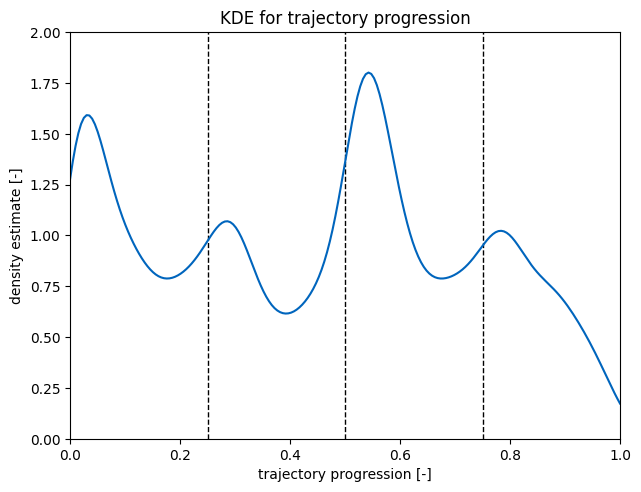

In [35]:
d, u, i = np.loadtxt('../data/match_traj.csv', delimiter=',')
i = i/np.max(i)


print(np.median(d), np.median(i))

density = stats.kde.gaussian_kde(i)
t = np.linspace(0, 1, 200)

cvut_blue = (0/255, 101/255, 189/255)

plt.vlines([0.25, 0.5, 0.75], 0, 2, colors='black', linestyles='dashed', linewidth=1)
plt.plot(t, density(t), c=cvut_blue)

plt.xlabel('trajectory progression [-]')
plt.ylabel('density estimate [-]')
plt.tight_layout()
plt.ylim([0, 2])
plt.xlim([0, 1])
plt.title('KDE for trajectory progression')
plt.savefig('../plots/density_prog.pdf', bbox_inches="tight")